# Function 1 - Radiation Field

### First Inspection

The first function describes a two-dimensional area, such as a radiation field, where only proximity yields a non-zero reading. Using Bayesian optimisation, the goal is to locate the largest radiation (contamination) source while making as few measurements/evaluations as possible. Since our black-box function is only 2D, we can visualise it with a scatter plot,

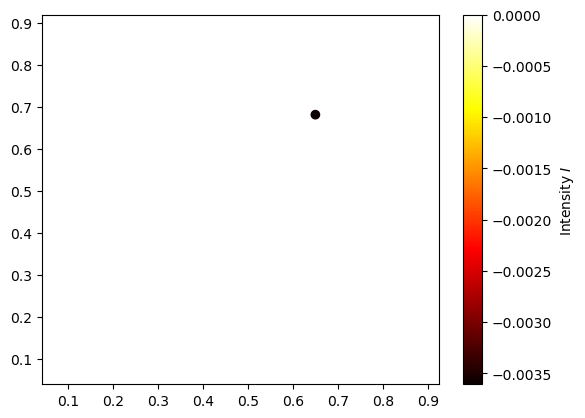

In [48]:
# Depedencies,
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# SKOPT imports,
from skopt import gp_minimize
from skopt.space import Real
from skopt.learning import GaussianProcessRegressor
from skopt.learning.gaussian_process.kernels import RBF, ConstantKernel
from skopt import Optimizer
from joblib import dump, load

# Loading known evaluations,
X, y = np.load("initial_inputs.npy"), np.load("initial_outputs.npy")

# Plotting,
plt.scatter(X.T[0], X.T[1], c=y, cmap="hot")
plt.plot()
plt.colorbar(label="Intensity $I$")
plt.show()

In [47]:
X

array([[0.31940389, 0.76295937],
       [0.57432921, 0.8798981 ],
       [0.73102363, 0.73299988],
       [0.84035342, 0.26473161],
       [0.65011406, 0.68152635],
       [0.41043714, 0.1475543 ],
       [0.31269116, 0.07872278],
       [0.68341817, 0.86105746],
       [0.08250725, 0.40348751],
       [0.88388983, 0.58225397]])

In [45]:
# Inspecting the output,
y

array([ 1.32267704e-079,  1.03307824e-046,  7.71087511e-016,
        3.34177101e-124, -3.60606264e-003, -2.15924904e-054,
       -2.08909327e-091,  2.53500115e-040,  3.60677119e-081,
        6.22985647e-048])

The domain of the black-box function has no been provided, but from the scatter plot we can see that it is likely to be $[0, 1]^2$ (representing a square area). We can see that the given evaluations have been near the corners of the area and have, for the most part with one exception, yield low values of intensity. Assuming an inverse square-law $I \propto r^{-2}$,low measured intensities at the boundaries of the domain imply that these points are relatively far from the radiation source(s). Conversely, the higher intensity observed closer to the centre suggests a shorter distance to the source. From this, it is reasonable to deduct that the source or sources of radiation are located nearer to the centre of the area. Therefore, we decide to holistically constrain the optimisation domain, 

x1 bound: (0.08250725182080587, 0.8838898288181171)
x2 bound: (0.07872277794971883, 0.879898104984359)


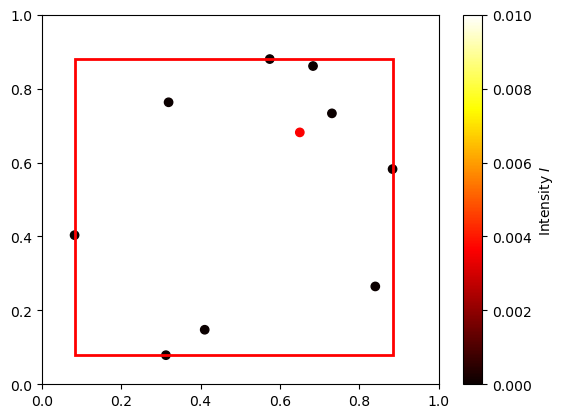

In [3]:
# Plotting,
fig, ax = plt.subplots()
sc = ax.scatter(X.T[0], X.T[1], c=-y, cmap="hot", vmax=0.01)
plt.colorbar(sc, ax=ax, label="Intensity $I$")

# Working out new bounds,
x1_min, x1_max = np.min(X.T[0]), np.max(X.T[0])
x2_min, x2_max = np.min(X.T[1]), np.max(X.T[1])
print(f"x1 bound: {(x1_min, x1_max)}")
print(f"x2 bound: {(x2_min, x2_max)}")

# Defiing smaller sampling region,
rect = patches.Rectangle(
    (x1_min, x2_min),    # bottom-left corner
    (x1_max - x1_min),   # width
    (x2_max - x2_min),   # height
    linewidth=2,
    edgecolor="red",
    facecolor="none"
)
ax.add_patch(rect)

# Infered domain,
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

# Showing,
plt.show()

The domain we now consider is $0.0825 \leq x_1 \leq 0.884$ and $0.0787 \leq x_2 \leq 0.880$. Another thing we notice is that some values are negative. This is not physical when modelling a radiation field is likely due to numerical noise. Furthermore, many values are extremely small which may cause our BO algorithm to be less stable. For these reasons, we transform the black-box output using a log transform,

$$
y_{trans} = \text{log}(\text{CLIP}(y, \epsilon))
$$

In [29]:
def log_transform(y, epsilon=1e-130):
    """We firstly clip any negative values to epsilon and take a log transform."""
    y = np.where(y <= 0, epsilon, y)
    return np.log(y)

### Optimiser Configuration

We do not know if the there is only single source or multiple sources of radiation. Hence, we do not know if we are dealing with a unimodal or multimodal function. Carrying on with assuming that the sources of radiation follow the inverse-square law, we can assume that the radiation field is mathematically smooth even if we have multiple sources. So far we have the following information,

- $f(\mathbf{x})$ is likely to be mathematically smooth.
- We do not know if $f(\mathbf{x})$ is unimodal or mutlimodal.
- Its maxima or maximum is likely to be located nearer to the centre of the parameter space.
- No noise has been mentioned in the function description.

In `skopt.Optimizer`, we have three main choices for the acquistion function: LCB, Expected Improvement (EI) and Probability of Improvement (PI). There are even more choices for the kernel, also know as the covariance function $\mathbf{K}$. It is unclear in pratical problems what an appropropriate choice for a kernel and its hyperparameter are (Snoek et al., 2012). Since we are dealing with a smooth function, the SE (squared exponential kernel), also know as the RBF kernel, and RQ (rational quadratic kernel) are the most obvious candidates. The RQ kernal is equivalent to adding together many SE kernels with different lengthscales (David Duvenaud, 2014) so it may seem like a better choice since we do not know the lengthscales (the distance at which points are strongly correlated) in our problem. However, `skopt` implements a ARD (automatic relevance determination) kernel in the `RBF` class which allows the kernel to adjust its length scale during the optimisation process. We select this kernel because it is able to handle multimodal functions which are smooth,

$$
K(x, x') = \sigma^2 \exp\Bigg[
- \frac{(x_1 - x_1')^2}{2 \ell_1^2} 
- \frac{(x_2 - x_2')^2}{2 \ell_2^2}
\Bigg]
$$

We make an educated guess that the length scales are $l_1 = l_2 = 0.1$ and the scaling constant is $\sigma = 1$. As for the acquisition function, we select PI over LCB since we do not have to specify any additional hyperparameter. PI chooses exploitation over exploration so we run the risk of getting stuck at a local maxima if there are multiple sources of radiation. 

### Optimiser Initialisation

We first intialise the optimiser with the evalutations points given by the problem. Note that we are minising the transformed function $ g(\mathbf{x}) = -\text{log}(\text{CLIP}(f(\mathbf{x}), \epsilon))$ which is equivalent of maximising the black-box function $f(\mathbf{x})$.

In [34]:
"""INITALISING THE OPTIMISATION MODEL."""

# Inputting the given evaluations provided by the problem,
X_supplied = X.tolist()
y_supplied = log_transform(y)
y_supplied = y_supplied.tolist()

"""OPTIMISER SETTINGS."""

# We define the domain of the black-box function (or the range of the parameter values we want to consider),
space = [Real(0.0825, 0.884, name="x1"),
         Real(0.0787, 0.880, name="x2")
         ]

# Creating the kernel for the GPR,
kernel = ConstantKernel(1.0) * RBF(
    length_scale=[0.1, 0.1],
    length_scale_bounds=(1e-2, 1)
)

# GPR settings,
gpr = GaussianProcessRegressor(
    kernel=kernel,
    normalize_y=True,
    n_restarts_optimizer=10
)

# Creating optimisier,
opt = Optimizer(
    dimensions=space,
    base_estimator=gpr,
    acq_func="LCB",
    acq_func_kwargs={"kappa": 0.5},
    random_state=0
)

"""CREATING INITIAL OPTIMISER STATE."""

# Supplying given points to optimiser,
opt.tell(X_supplied, (-np.array(y_supplied)).tolist()) # <-- We flip the values since we are trying to maximise the black-box function.

# Asking for the next point to evaluate the black-box function,
point_query = opt.ask()

# Saving optimiser state (zero-th iteration),
dump(opt, "bayes_opt_state_iter0.joblib")

# Printing point query,
print(f"Point Query: {point_query}")

Point Query: [0.8433466740177721, 0.7363731552901824]


### Next Query

Load and ask the optimiser for the next point based on the previous evalutation result.

In [ ]:
# Specify the current interation,
current_query = 1

# Input the new evaluation,
X_new = [[]]
y_new = []

# Transform black-box output,
y_new = log_transform(y_new).tolist()

# Loading the previous state of the optimiser,
opt = load(f"bayes_opt_state_iter{current_query - 1}.joblib")

# Supplying the new query to the optimiser,
opt.tell(X_new, (-np.array(y_new)).tolist()) # <-- We flip the values since we are trying to maximise the black-box function.

# Asking for the next point to evaluate the black-box function,
point_query = opt.ask()

# Saving optimiser state,
dump(opt, f"bayes_opt_state_iter{current_query}.joblib")

# Printing point query,
print(f"Point Query {current_query + 1}: {point_query}")

Point Query 2: [0.7258572437999095, 0.7319450456407999]


### Visualising Progression

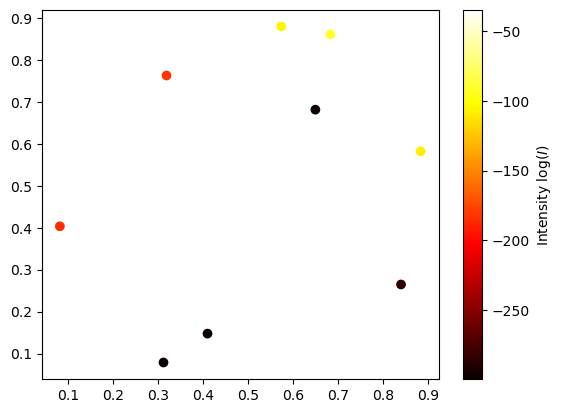

In [43]:
# Loading know evaluations,
X, y = np.load("initial_inputs.npy"), np.load("initial_outputs.npy")

# New evaluations,
X_new = [[0.732787, 0.733181]]
y_new = [3.5897238714370422e-16]

# Concatenating,
X = np.concatenate((X, X_new), axis=0)
y = np.concatenate((y, y_new), axis=0)
y = log_transform(y)

# Plotting,
plt.scatter(X.T[0], X.T[1], c=y, cmap="hot")
plt.plot()
plt.colorbar(label=r"Intensity $\text{log}({I})$")
plt.show()

In [7]:
y

array([ 1.32267704e-079,  1.03307824e-046,  7.71087511e-016,
        3.34177101e-124, -3.60606264e-003, -2.15924904e-054,
       -2.08909327e-091,  2.53500115e-040,  3.60677119e-081,
        6.22985647e-048])

### Updates

Week 1: The black-box function $f(\mathbf{x})$ was evaluated at [0.732787, 0.733181] and returned a value of $3.59 \times 10^{-16}$. It was not realised that this new query was in very close proximity to the known evaluation [0.73102363, 0.73299988] yielding $7.71 \times 10^{-16}$. It seems that the PI acquisition function over-exploits in this case. Therefore, the optimiser was reset, but with a $\kappa = 1.0$ LCB acquisition function instead. As a 

### References

1. PRACTICAL BAYESIAN OPTIMIZATION OF MACHINE LEARNING ALGORITHMS. Jasper Snoek, Hugo Larochelle and Ryan P. Adams. 2012.